
## 🩺 Definição do Problema
Este projeto investiga a detecção de manipulações artificiais em Imagem por Ressonância Magnética (MRI), incluindo técnicas de injection (adição de nódulos falsos) e removal (remoção de lesões reais). Com o aumento de fraudes e modificações digitais em exames, torna-se essencial desenvolver métodos automáticos que identifiquem alterações e apoiem a triagem e auditoria clínica.

## 🎯 Objetivos
Treinar um modelo baseado em EfficientNet-B3 para classificar diferentes tipos de manipulação em exames de MRI.

Avaliar o desempenho por métricas clássicas de classificação.

Aplicar métodos de explicabilidade (Grad-CAM) para entender onde o modelo foca.

Gerar visualizações úteis para validação clínica e auditoria.

👥 Personas
Pessoas que precisam verificar a autenticidade dos exames.

Desenvolvedores de sistemas de auditoria e detecção de fraudes médicas.

❓ Perguntas de Pesquisa
O modelo consegue identificar imagens manipuladas de forma confiável?

As regiões destacadas pelo Grad-CAM fazem sentido para validação clínica?

## Setup


In [ ]:
!pip install timm kaggle
!pip install torch torchvision torchaudio
!pip install scikit-learn pandas matplotlib

In [ ]:
import json, os
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import timm
import cv2
import time

from google.colab import drive, userdata

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from torchvision import transforms
from PIL import Image

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, f1_score
from sklearn.preprocessing import LabelBinarizer

## Baixando o dataset do Kaggle
URL: https://www.kaggle.com/datasets/freddiegraboski/btd-mri-and-ct-deepfake-test-sets?select=MRI

In [ ]:
token = userdata.get("KAGGLE_API_TOKEN")

KAGGLE_USERNAME = "lauratracierra"

try:
    kaggle_dict = json.loads(token)
    print("✅ Token detectado como JSON.")
except:
    print("⚠️ Token não é JSON, tratando como KEY simples.")
    kaggle_dict = {
        "username": KAGGLE_USERNAME,
        "key": token.strip()
    }

os.makedirs("/root/.kaggle", exist_ok=True)

with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump(kaggle_dict, f)

os.chmod("/root/.kaggle/kaggle.json", 0o600)

print("✅ kaggle.json criado com sucesso!")


⚠️ Token não é JSON, tratando como KEY simples.
✅ kaggle.json criado com sucesso!


In [ ]:
!kaggle datasets download -d freddiegraboski/btd-mri-and-ct-deepfake-test-sets -p /content --unzip


Dataset URL: https://www.kaggle.com/datasets/freddiegraboski/btd-mri-and-ct-deepfake-test-sets
License(s): GNU Affero General Public License 3.0
 99% 1.25G/1.25G [00:06<00:00, 231MB/s]
100% 1.25G/1.25G [00:06<00:00, 222MB/s]


## Dataset
O dataset contém imagens de Imagem por Ressonância Magnética (MRI) em .png. Ele inclui diferentes cenários de manipulação produzidos por Stable Diffusion e imagens reais.

Classe de manipulação (ex.: FB, FM); Classe real (ex: TM e TB)

Classes:

Injection:
- FM: Fake-Malign (cancer added using Stable Diffusion)
- TM: True-Malign (authentic images with malignant tumors)

Removal:
- FB: Fake-Benign (cancer removed using Stable Diffusion)
- TB: True-Benign (authentic images without tumors)
Estrutura hierárquica mantendo injection e removal originais.

O dataset é organizado em pastas por classe, e depois dividido em treino, validação e teste (70/15/15).

In [ ]:
# --- 1. Carregar e Combinar os Dados ---

try:
    df_inj = pd.read_csv('/content/MRI/MRI_injection.csv')
    df_rem = pd.read_csv('/content/MRI/MRI_removal.csv')
except FileNotFoundError:
    print("Erro: Verifique se 'MRI_injection.csv' e 'MRI_removal.csv' estão no diretório atual.")
    df_inj = pd.read_csv('/content/MRI/MRI_injection.csv')
    df_rem = pd.read_csv('/content/MRI/MRI_removal.csv')

# 1.1. Combinar os dois DataFrames
df_full = pd.concat([df_inj, df_rem], ignore_index=True)

# 1.2. Renomear colunas para clareza
df_full.rename(columns={'type': 'Class', 'path': 'ImagePath'}, inplace=True)


# --- 2. Configuração para Divisão ---

TRAIN_SIZE = 0.7  # 70%
VALID_SIZE = 0.15  # 15%
RANDOM_SEED = 42  # Para resultados replicáveis


# --- 3. Divisão do Dataset (Treino, Validação, Teste) ---

# 3.1. Primeira divisão: Treino (70%) vs. Temporário (Teste + Validação = 30%)
df_train, df_temp = train_test_split(
    df_full,
    train_size=TRAIN_SIZE,
    random_state=RANDOM_SEED,
    stratify=df_full['Class']
)

# 3.2. Segunda divisão: Dividir o Temporário (30%) em Validação (15%) e Teste (15%)
df_valid, df_test = train_test_split(
    df_temp,
    test_size=0.5,
    random_state=RANDOM_SEED,
    # Estratificação no conjunto temporário
    stratify=df_temp['Class']
)

# --- 4. Salvar DataFrames em CSVs ---

df_train.to_csv('mri_train.csv', index=False)
df_valid.to_csv('mri_valid.csv', index=False)
df_test.to_csv('mri_test.csv', index=False)

print("Divisão concluída!")
print(f"Arquivos gerados: mri_train.csv ({len(df_train)} amostras), mri_valid.csv ({len(df_valid)} amostras), mri_test.csv ({len(df_test)} amostras)")

Divisão concluída!
Arquivos gerados: mri_train.csv (489 amostras), mri_valid.csv (105 amostras), mri_test.csv (106 amostras)


In [ ]:
class_counts = df_train['Class'].value_counts(sort=False)

In [ ]:
# 1. Obter os rótulos do conjunto de treinamento (usando a coluna 'Class')
# Certifique-se de que a ordem das classes aqui corresponde à ordem do seu class_to_idx
y_train = df_train['Class'].values # Use a coluna Class_ID que você criou

# 2. Calcular os pesos (usando scikit-learn para garantir a ordem correta)
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)

# 3. Converter para Tensor e mover para a GPU
class_weights = torch.tensor(weights, dtype=torch.float).to(DEVICE)

### 📊 Estatísticas por classe

No próximo bloco vamos contar quantas imagens existem em cada categoria
para entender se há desbalanceamento.

In [ ]:
# Carregar os três conjuntos de dados salvos
# Estes são os arquivos CSV gerados na etapa anterior.
df_train = pd.read_csv('mri_train.csv')
df_valid = pd.read_csv('mri_valid.csv')
df_test = pd.read_csv('mri_test.csv')

# Combinar em um DataFrame temporário para análise da contagem total
df_full = pd.concat([df_train, df_valid, df_test], ignore_index=True)

# 1. Contagem total de amostras por classe no dataset completo
total_counts = df_full['Class'].value_counts().sort_index()

# 2. Contagem de amostras por classe em cada conjunto individual
train_counts = df_train['Class'].value_counts().sort_index()
valid_counts = df_valid['Class'].value_counts().sort_index()
test_counts = df_test['Class'].value_counts().sort_index()

# 3. Criar um DataFrame de resumo para visualização tabular
summary_df = pd.DataFrame({
    'Total': total_counts,
    'Treino': train_counts,
    'Validação': valid_counts,
    'Teste': test_counts
}).fillna(0).astype(int) # Preencher valores faltantes (se houver) com 0 e converter para inteiro

# 4. Imprimir o resumo das contagens
print("--- Resumo da Distribuição de Classes (Contagens) ---")
print(summary_df)

# 5. Imprimir a proporção das classes no dataset total
print("\n--- Proporção de Classes no Total (%) ---")
print((total_counts / total_counts.sum() * 100).round(2))

--- Resumo da Distribuição de Classes (Contagens) ---
       Total  Treino  Validação  Teste
Class                                 
FB       175     122         27     26
FM       175     123         26     26
TB       175     122         26     27
TM       175     122         26     27

--- Proporção de Classes no Total (%) ---
Class
FB    25.0
FM    25.0
TB    25.0
TM    25.0
Name: count, dtype: float64


## Modelo
### ViT

In [ ]:
# --- CONFIGURAÇÃO ---
NUM_CLASSES = 4
BATCH_SIZE = 32
LEARNING_RATE = 5e-5
NUM_EPOCHS = 15
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ViT requer imagens de 224x224
IMG_SIZE = 224
BASE_DIR = '/content/' # Assumindo que os arquivos CSV e a pasta de imagens estão aqui

# --- DATASET CUSTOMIZADO ---
class MRI_ViT_Dataset(Dataset):
    def __init__(self, csv_file, base_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.base_dir = base_dir
        self.transform = transform

        # Mapeamento de classes (Strings para Inteiros)
        class_to_idx = {'FB': 0, 'FM': 1, 'TB': 2, 'TM': 3}
        self.data_frame['Class'] = self.data_frame['Class'].map(class_to_idx)

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        # O caminho completo é a junção do diretório base e o caminho relativo no CSV
        img_path = os.path.join(self.base_dir, self.data_frame.iloc[idx]['ImagePath'].lstrip('/'))

        try:
            image = Image.open(img_path).convert('L')

        except FileNotFoundError:
            # Caso o arquivo não exista, retorne um erro ou uma imagem placeholder para depuração
            print(f"Erro ao carregar imagem: {img_path}. Verifique a estrutura de pastas.")
            return None, None # Deve ser tratado no DataLoader

        label = self.data_frame.iloc[idx]['Class']

        if self.transform:
            image = self.transform(image)

        return image, label
GRAYSCALE_MEAN = [0.5]
GRAYSCALE_STD = [0.5]
# --- TRANSFORMAÇÕES ---
# O ViT espera normalização padrão para imagens pré-treinadas no ImageNet
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomAffine(
        degrees=5,
        translate=(0.02, 0.02),
        scale=(0.98, 1.02),
        shear=2,
    ),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=GRAYSCALE_MEAN, std=GRAYSCALE_STD)
])

# --- CRIAÇÃO DE DATALOADERS ---
train_dataset = MRI_ViT_Dataset(os.path.join(BASE_DIR, 'mri_train.csv'), BASE_DIR, train_transforms)
valid_dataset = MRI_ViT_Dataset(os.path.join(BASE_DIR, 'mri_valid.csv'), BASE_DIR, val_test_transforms)
test_dataset = MRI_ViT_Dataset(os.path.join(BASE_DIR, 'mri_test.csv'), BASE_DIR, val_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# --- DEFINIÇÃO DO MODELO ViT (Vision Transformer) ---
# Usando o ViT-base pré-treinado
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=NUM_CLASSES)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)

# Otimizador e Função de Custo
criterion = nn.CrossEntropyLoss()
for name, param in model.named_parameters():
    # Congela todas as camadas exceto o 'head' (classificador)
    if 'head' not in name:
        param.requires_grad = False

# Otimizador deve considerar apenas os parâmetros treináveis:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)

# --- FUNÇÃO DE TREINAMENTO ---
def train_model():
    best_val_acc = 0.0

    print(f"Iniciando treinamento em {DEVICE} por {NUM_EPOCHS} épocas...")
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            if inputs is None: continue # Ignora amostras com erro de carregamento
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_dataset)

        # --- VALIDAÇÃO (a cada época) ---
        val_loss, val_acc = evaluate_model(valid_loader)

        print(f"Época {epoch+1}/{NUM_EPOCHS} - "
              f"Treino Loss: {epoch_loss:.4f} - "
              f"Validação Loss: {val_loss:.4f} - "
              f"Validação Acc: {val_acc:.4f}")

        # Salva o melhor modelo
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_vit_model.pth')
            print("Modelo salvo. Nova melhor acurácia de validação.")

# --- FUNÇÃO DE AVALIAÇÃO AUXILIAR ---
def evaluate_model(data_loader):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            if inputs is None: continue
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()

    avg_loss = running_loss / len(data_loader.dataset)
    accuracy = correct_predictions / len(data_loader.dataset)
    return avg_loss, accuracy

# --- EXECUÇÃO DO TREINAMENTO ---
train_model()

Iniciando treinamento em cuda por 15 épocas...
Época 1/15 - Treino Loss: 1.5353 - Validação Loss: 1.4594 - Validação Acc: 0.2095
Modelo salvo. Nova melhor acurácia de validação.
Época 2/15 - Treino Loss: 1.4513 - Validação Loss: 1.4685 - Validação Acc: 0.2476
Modelo salvo. Nova melhor acurácia de validação.
Época 3/15 - Treino Loss: 1.4441 - Validação Loss: 1.5010 - Validação Acc: 0.2000
Época 4/15 - Treino Loss: 1.4102 - Validação Loss: 1.4351 - Validação Acc: 0.2476
Época 5/15 - Treino Loss: 1.3933 - Validação Loss: 1.4826 - Validação Acc: 0.2190
Época 6/15 - Treino Loss: 1.3937 - Validação Loss: 1.4244 - Validação Acc: 0.2952
Modelo salvo. Nova melhor acurácia de validação.
Época 7/15 - Treino Loss: 1.3675 - Validação Loss: 1.4192 - Validação Acc: 0.2667


KeyboardInterrupt: 

📊 Avaliação no Conjunto de Teste
Acurácia Global: 0.3208
F1-Score (Ponderado): 0.3178

--- Classification Report ---
              precision    recall  f1-score   support

          FB       0.34      0.42      0.38        26
          FM       0.32      0.27      0.29        26
          TB       0.30      0.33      0.32        27
          TM       0.32      0.26      0.29        27

    accuracy                           0.32       106
   macro avg       0.32      0.32      0.32       106
weighted avg       0.32      0.32      0.32       106

AUC (One-vs-Rest): 0.5411


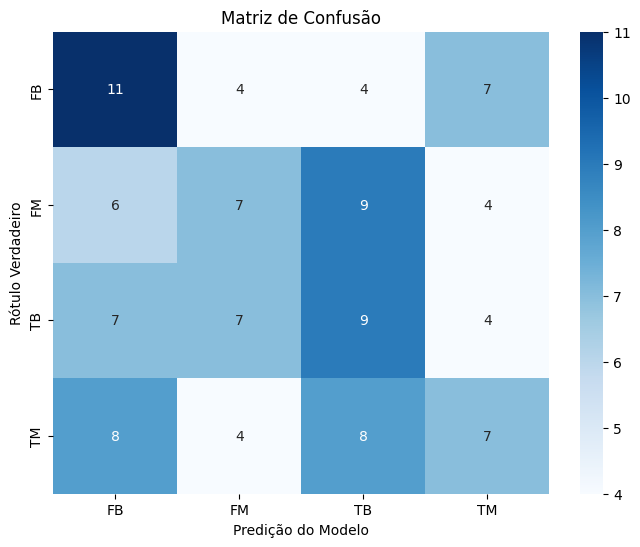

In [ ]:
# --- CARREGAR O MELHOR MODELO ---
model.load_state_dict(torch.load('best_vit_model.pth'))
model.eval()

# --- PREDIÇÕES NO CONJUNTO DE TESTE ---
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        if inputs is None: continue
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- CÁLCULO E IMPRESSÃO DE MÉTRICAS ---
labels_names = ['FB', 'FM', 'TB', 'TM']

# 1. Acurácia e F1-Score
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')

print("==================================================")
print(f"📊 Avaliação no Conjunto de Teste")
print("==================================================")
print(f"Acurácia Global: {acc:.4f}")
print(f"F1-Score (Ponderado): {f1:.4f}")

# 2. Classification Report
print("\n--- Classification Report ---")
print(classification_report(all_labels, all_preds, target_names=labels_names))

# 3. AUC (Area Under the Curve)
y_true_bin = LabelBinarizer().fit_transform(all_labels)
all_probas = []

with torch.no_grad():
    for inputs, _ in test_loader:
        if inputs is None: continue
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        probas = torch.softmax(outputs, dim=1)
        all_probas.extend(probas.cpu().numpy())

auc_score = roc_auc_score(y_true_bin, all_probas, multi_class='ovr')
print(f"AUC (One-vs-Rest): {auc_score:.4f}")

# 4. Matriz de Confusão
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_names, yticklabels=labels_names)
plt.title('Matriz de Confusão')
plt.ylabel('Rótulo Verdadeiro')
plt.xlabel('Predição do Modelo')
plt.show() # Exibe a matriz de confusão

### EfficientNetB3

In [ ]:
# --- DEFINIÇÃO DO MODELO EfficientNetB3 ---
# Constantes usadas
NUM_CLASSES = 4
BATCH_SIZE = 32
LEARNING_RATE = 1e-5
NUM_EPOCHS = 30
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 224

# Carrega o EfficientNet B3 pré-treinado no ImageNet
model = timm.create_model('tf_efficientnet_b3_ns', pretrained=True, num_classes=NUM_CLASSES)
# 2. Adapta a primeira camada (conv_stem)
original_conv_weight = model.conv_stem.weight.clone()

# Cria a nova camada com 1 canal
new_conv_stem = nn.Conv2d(
    in_channels=1, # 1 canal (Grayscale)
    out_channels=model.conv_stem.out_channels,
    kernel_size=model.conv_stem.kernel_size,
    stride=model.conv_stem.stride,
    padding=model.conv_stem.padding,
    bias=model.conv_stem.bias is not None
)

# Transfere os pesos pré-treinados (média dos 3 canais originais)
new_conv_stem.weight.data = original_conv_weight.data.mean(dim=1, keepdim=True)

# Substitui a camada no modelo
model.conv_stem = new_conv_stem

model.to(DEVICE)

# --- CONFIGURAÇÃO DE FINE-TUNING (Congelamento) ---
# Congelamos o "feature extractor" (camadas de base) e treinamos apenas o "classifier" (cabeça)
for name, param in model.named_parameters():
    # EfficientNet usa 'classifier' como nome da camada final
    if 'classifier' not in name:
        param.requires_grad = False

# Otimizador e Função de Custo
# Passamos apenas os parâmetros que não foram congelados (requires_grad=True)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# 1. Torne TODOS os parâmetros não-treináveis primeiro:
for param in model.parameters():
    param.requires_grad = False

# 2. Descongela as últimas 2-3 camadas (blocos) e o classificador:
# Descongelar o classificador (head)
for param in model.classifier.parameters():
    param.requires_grad = True

# Descongelar o penúltimo bloco (ex: model.blocks[5] e model.blocks[6] para EfficientNetB3)
for i in range(4, 7): # Blocos 4, 5 e 6
    for param in model.blocks[i].parameters():
        param.requires_grad = True
optimizer = optim.Adam([
    {"params": model.blocks[4].parameters(), "lr": 1e-4},
    {"params": model.blocks[5].parameters(), "lr": 1e-4},
    {"params": model.blocks[6].parameters(), "lr": 1e-4},
    {"params": model.classifier.parameters(), "lr": 5e-4},
])

print(f"Novo Número de Parâmetros Treináveis: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")


# --- FUNÇÃO DE TREINAMENTO ---
def train_model(train_loader, valid_loader, NUM_EPOCHS):
    best_val_acc = 0.0

    print(f"Iniciando treinamento EfficientNetB3 em {DEVICE} por {NUM_EPOCHS} épocas...")
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            if inputs is None: continue
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        # --- VALIDAÇÃO (a cada época) ---
        val_loss, val_acc = evaluate_model(valid_loader)

        print(f"Época {epoch+1}/{NUM_EPOCHS} - "
              f"Treino Loss: {epoch_loss:.4f} - "
              f"Validação Loss: {val_loss:.4f} - "
              f"Validação Acc: {val_acc:.4f}")

        # Salva o melhor modelo
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_efficientnet_model.pth')
            print("Modelo salvo. Nova melhor acurácia de validação.")

# --- FUNÇÃO DE AVALIAÇÃO AUXILIAR (Mantida) ---
def evaluate_model(data_loader):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            if inputs is None: continue
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()

    avg_loss = running_loss / len(data_loader.dataset)
    accuracy = correct_predictions / len(data_loader.dataset)
    return avg_loss, accuracy

# --- EXECUÇÃO DO TREINAMENTO ---
train_model(train_loader, valid_loader, NUM_EPOCHS)

/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name tf_efficientnet_b3_ns to current tf_efficientnet_b3.ns_jft_in1k.
  model = create_fn(


Novo Número de Parâmetros Treináveis: 9307090
Iniciando treinamento EfficientNetB3 em cuda por 30 épocas...
Época 1/30 - Treino Loss: 2.2356 - Validação Loss: 2.4545 - Validação Acc: 0.3048
Modelo salvo. Nova melhor acurácia de validação.
Época 2/30 - Treino Loss: 1.1499 - Validação Loss: 2.4781 - Validação Acc: 0.2762
Época 3/30 - Treino Loss: 0.8929 - Validação Loss: 2.5509 - Validação Acc: 0.3143
Modelo salvo. Nova melhor acurácia de validação.
Época 4/30 - Treino Loss: 0.7930 - Validação Loss: 2.4735 - Validação Acc: 0.3048
Época 5/30 - Treino Loss: 0.7373 - Validação Loss: 1.7975 - Validação Acc: 0.3714
Modelo salvo. Nova melhor acurácia de validação.
Época 6/30 - Treino Loss: 0.7290 - Validação Loss: 1.6690 - Validação Acc: 0.4571
Modelo salvo. Nova melhor acurácia de validação.
Época 7/30 - Treino Loss: 0.7039 - Validação Loss: 1.2369 - Validação Acc: 0.5048
Modelo salvo. Nova melhor acurácia de validação.
Época 8/30 - Treino Loss: 0.5710 - Validação Loss: 1.3576 - Validação Acc

## Métricas

📊 Avaliação no Conjunto de Teste
Acurácia Global: 0.5566
F1-Score (Ponderado): 0.5640

--- Classification Report ---
              precision    recall  f1-score   support

          FB       0.96      0.96      0.96        26
          FM       1.00      0.92      0.96        26
          TB       0.17      0.19      0.18        27
          TM       0.19      0.19      0.19        27

    accuracy                           0.56       106
   macro avg       0.58      0.56      0.57       106
weighted avg       0.57      0.56      0.56       106

AUC (One-vs-Rest): 0.8247


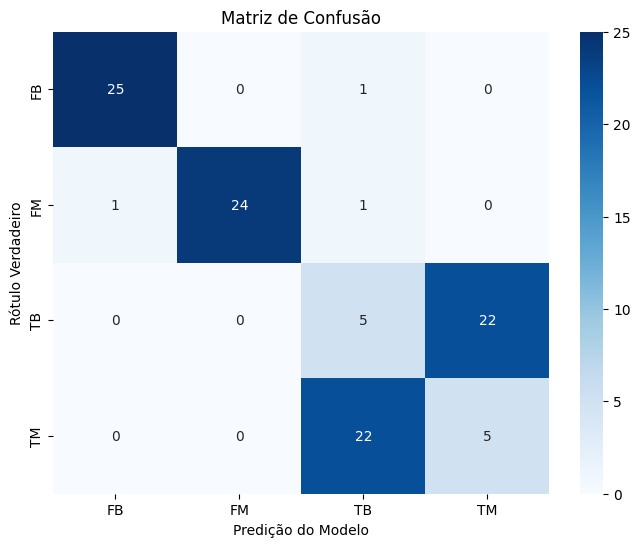

In [ ]:
# --- CARREGAR O MELHOR MODELO ---
model.load_state_dict(torch.load('best_efficientnet_model.pth'))
model.eval()

# --- PREDIÇÕES NO CONJUNTO DE TESTE ---
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        if inputs is None: continue
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- CÁLCULO E IMPRESSÃO DE MÉTRICAS ---
labels_names = ['FB', 'FM', 'TB', 'TM']

# 1. Acurácia e F1-Score
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')

print("==================================================")
print(f"📊 Avaliação no Conjunto de Teste")
print("==================================================")
print(f"Acurácia Global: {acc:.4f}")
print(f"F1-Score (Ponderado): {f1:.4f}")

# 2. Classification Report
print("\n--- Classification Report ---")
print(classification_report(all_labels, all_preds, target_names=labels_names))

# 3. AUC (Area Under the Curve)
y_true_bin = LabelBinarizer().fit_transform(all_labels)
all_probas = []

with torch.no_grad():
    for inputs, _ in test_loader:
        if inputs is None: continue
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        probas = torch.softmax(outputs, dim=1)
        all_probas.extend(probas.cpu().numpy())

auc_score = roc_auc_score(y_true_bin, all_probas, multi_class='ovr')
print(f"AUC (One-vs-Rest): {auc_score:.4f}")

# 4. Matriz de Confusão
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_names, yticklabels=labels_names)
plt.title('Matriz de Confusão')
plt.ylabel('Rótulo Verdadeiro')
plt.xlabel('Predição do Modelo')
plt.show() # Exibe a matriz de confusão

## Explicabilidade (Grad-CAM)

/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name tf_efficientnet_b3_ns to current tf_efficientnet_b3.ns_jft_in1k.
  model = create_fn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


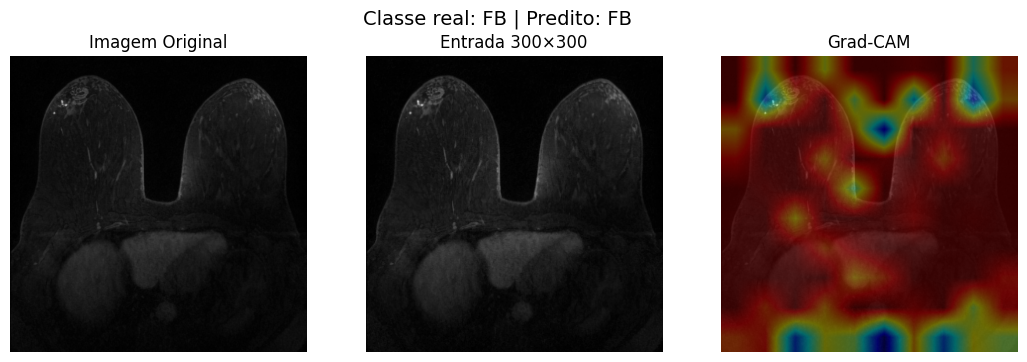

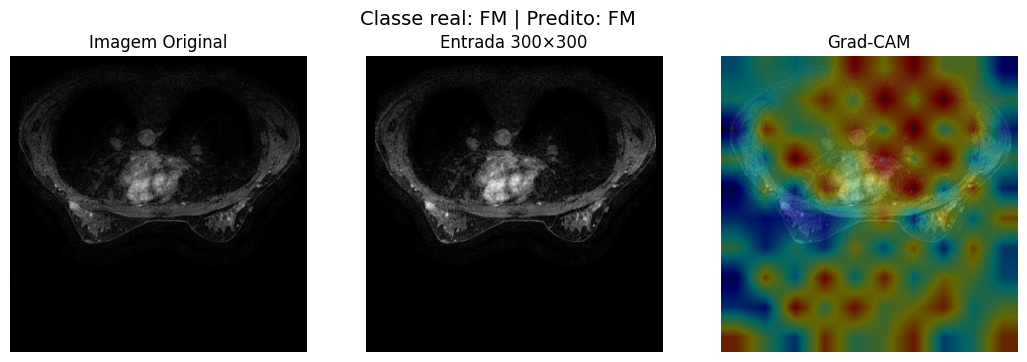

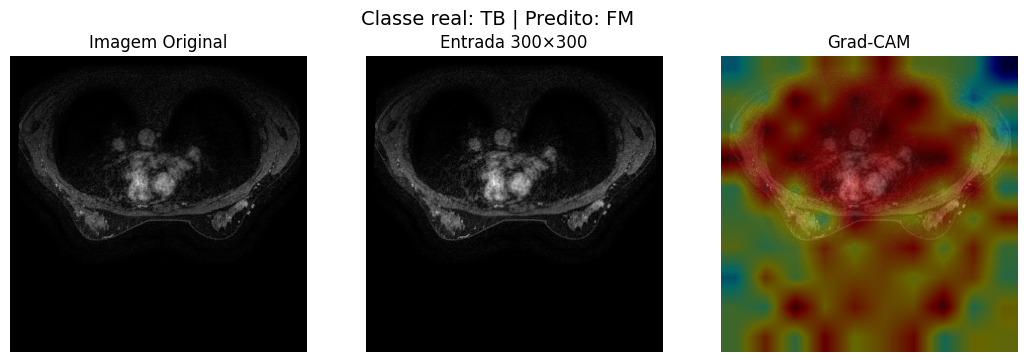

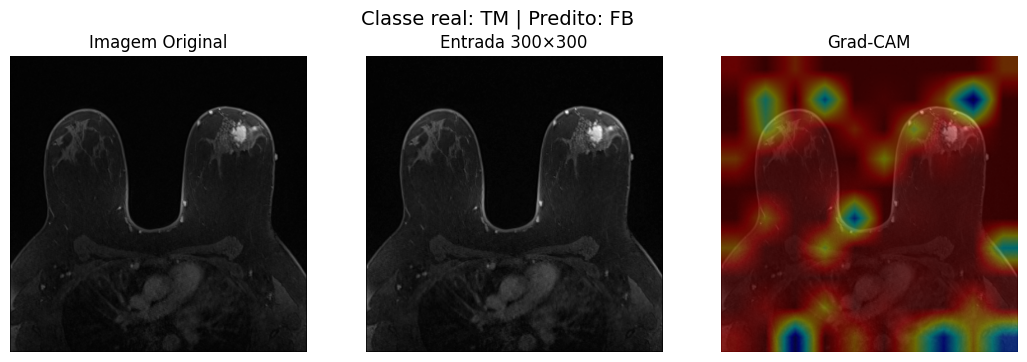

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# ==============================
# 1. Carregar CSV
# ==============================
df = pd.read_csv("/content/mri_test.csv")

classes = ["FB", "FM", "TB", "TM"]
samples = {}

for c in classes:
    row = df[df["Class"] == c].iloc[0]
    samples[c] = (row["ImagePath"], row["Class"])


# ==============================
# 2. Recriar EfficientNet-B3 NS com 1 canal
# ==============================
model = timm.create_model(
    "tf_efficientnet_b3_ns",
    pretrained=False,
    num_classes=4,
    in_chans=1       # <==== modelo foi treinado em grayscale
).to(device)

state = torch.load("/content/best_efficientnet_model.pth", map_location=device)
model.load_state_dict(state)
model.eval()

# última camada conv
target_layer = model.conv_head


# ==============================
# 3. Função Grad-CAM
# ==============================
def get_gradcam(img_tensor):
    activations = []
    gradients = []

    def forward_hook(module, inp, out):
        activations.append(out)

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    h1 = target_layer.register_forward_hook(forward_hook)
    h2 = target_layer.register_backward_hook(backward_hook)

    img_tensor = img_tensor.to(device)
    out = model(img_tensor)

    pred_idx = torch.argmax(out, dim=1).item()

    model.zero_grad()
    out[0, pred_idx].backward()

    acts = activations[0].detach().cpu().numpy()[0]
    grads = gradients[0].detach().cpu().numpy()[0]

    weights = np.mean(grads, axis=(1, 2))
    cam = np.zeros(acts.shape[1:], dtype=np.float32)

    for w, a in zip(weights, acts):
        cam += w * a

    cam = np.maximum(cam, 0)
    cam = cam / (cam.max() + 1e-8)

    h1.remove()
    h2.remove()

    return cam, pred_idx


# ==============================
# 4. Transformações
# ==============================
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((300, 300)),  # EfficientNet-B3 usa 300x300
    transforms.Grayscale(num_output_channels=1),    # <==== obrigatorio
    transforms.ToTensor(),
])


# ==============================
# 5. Mostrar 1 imagem por classe
# ==============================
for c in classes:

    img_path, true_label = samples[c]

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # carregar como cinza
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)   # só p/ visualizar no notebook

    img_resized = cv2.resize(img, (300, 300))
    img_tensor = transform(img_resized).unsqueeze(0)

    cam, pred_idx = get_gradcam(img_tensor)
    pred_label = classes[pred_idx]

    cam = (cam - cam.min()) / (cam.max() - cam.min())

    # redimensionar para o tamanho da imagem exibida
    h, w, _ = img_rgb.shape
    heatmap = cv2.resize(cam, (w, h))

    # colormap
    heatmap_color = cv2.applyColorMap((heatmap * 255).astype(np.uint8), cv2.COLORMAP_JET)

    # sobrepor (heatmap + imagem original)
    superimposed = cv2.addWeighted(img_rgb, 0.6, heatmap_color, 0.4, 0)

    plt.figure(figsize=(13,4))
    plt.suptitle(f"Classe real: {true_label} | Predito: {pred_label}", fontsize=14)

    plt.subplot(1,3,1)
    plt.imshow(img_rgb, cmap="gray")
    plt.axis("off")
    plt.title("Imagem Original")

    plt.subplot(1,3,2)
    plt.imshow(img_resized, cmap="gray")
    plt.axis("off")
    plt.title("Entrada 300×300")

    plt.subplot(1,3,3)
    plt.imshow(superimposed)
    plt.axis("off")
    plt.title("Grad-CAM")

    plt.show()
